# Notebook for paper

# This file outlines the paper


# Abstract
- Optimizing approach of Tactile & textile skin signal processing
- Contributions
    * Framing the problem as a circuit component parameter estimation problem, designing a Regularized least squares objective function for improved accuracy touch dynamic circuit component parameter estimation problem
    * Improved scanning method & reference resistors increasing dynamic range
    * Simplified skin design for easier manufacturing


# Literature
- Tactile skin
- HW (adding reference resistors, removing middle layer)
- SW (bias/scaling)
- Resistor Matrix
    * https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7790835


# Introduction
- 

# Method
- Determining the optimal reference resistor value
- Formulation of the math problem
- Algorithmic description of the signal processing pipeline


### Determining the optimal reference resistor value
- https://arxiv.org/pdf/1901.03811.pdf
- http://www.inf.u-szeged.hu/miszak/en/arduino-corner/arduino-ohmmeter-calculator/

- Spec
    * Our skin has a resistance range of 10kOhm to 5MOhm
    * Arduino ADC has a resolution of 10bit
    * Arduino ADC has a reference voltage of 5V
    * Arduino ADC has a resolution of 5V/1024 = 4.88mV
    * Arduino ADC has a error of 2 LSB

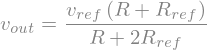

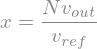

R =


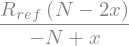

In [4]:
## Derive the equation for the unknown resistance R represented by measured unit x

from sympy import *
init_printing() 

# v_out: measured voltage
# v_ref: reference voltage
# R: unknown resistance
# R_ref: reference resistance
# N: total units
# x: measured units
v_out, v_ref, R, R_ref, N, x, x_err, R_ref_err = symbols('v_out v_ref R R_ref N x x_err R_ref_err')

# voltage divider equation
v_div_eq = Eq(v_out, ((R + R_ref)/ (R_ref + R + R_ref)) * v_ref)
display(v_div_eq)

# ADC equation
adc_eq = Eq(x, N * (v_out / v_ref))
display(adc_eq)
v_out_ = solve(adc_eq, v_out)[0]

# solve for R
print("R =")
R_ = simplify(solve(v_div_eq, R)[0].subs(v_out, v_out_))
display(R_)


dR/dx =


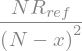

In [5]:
## Find derivative of R with respect to x
print("dR/dx =")
dR_dx = simplify(diff(R_, x))
display(dR_dx)


dR/R =


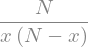

In [32]:
## Find dR/R
print("dR/R =")
dR_R = simplify(dR_dx / R_)
display(dR_R)

<lambdifygenerated-11>:2: RuntimeWarning: divide by zero encountered in divide
  return 2048/(x*(1024 - x))


Text(0.5, 1.0, 'dR/R vs x')

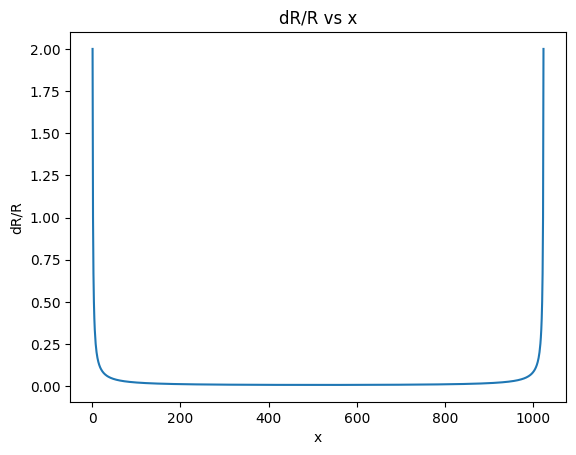

In [36]:
## plot dR/R given N = 1024
import matplotlib.pyplot as plt
import numpy as np

N_ = 1024
x_err_ = 2
x_ = np.linspace(0, N_, 1024)
dR_R_dx = dR_R * x_err
dR_R_arr = lambdify(x, dR_R_dx.subs(N, N_).subs(x_err, x_err_))(x_)

# plot
plt.plot(x_, dR_R_arr)
plt.xlabel("x")
plt.ylabel("dR/R")
plt.title("dR/R vs x")

In [54]:
## Find reference reistance R_ref given R_max, R_min, and N

R_min_c = 50e3
R_max_c = 1500e3

# for optimal resolution, corresponding x_min and x_max should be centered around N/2
x_min, x_max, R_min, R_max = symbols('x_min x_max R_min R_max')
opt_x_eq = Eq(x_min + x_max, N)

# expression for R_min and R_max
R_min_ = R_.subs(x, x_min)
R_min_eq = Eq(R_min, R_min_)
R_max_ = R_.subs(x, x_max)
R_max_eq = Eq(R_max, R_max_)

# solve for x_min and x_max
x_min_ = solve(R_min_eq, x_min)[0]
x_max_ = solve(R_max_eq, x_max)[0]

# solve for R_ref
print("R_ref =")
R_ref_ = simplify(solve(opt_x_eq.subs(x_min, x_min_).subs(x_max, x_max_), R_ref)[0])
display(R_ref_)

# find R_ref
print("=")
R_ref_ = simplify(R_ref_.subs(R_min, R_min_c).subs(R_max, R_max_c).subs(N, N_))
display(R_ref_)




R_ref =


=


## Formulation of the math problem

Let $V(i, j, k)$ be the $k$ th voltage measurement targeting cell at column $i$ and row $j$. \
For each cell, we make $4$ measurements, where $k \in \{1, 2, 3, 4\}$. \
**In the first measurement**, we apply a voltage of $V_{cc}$ to the $i$ th column and $0$ to the $j$ th row. $V(i, j, 1)$ is the voltage measured at the analog input pin placing at the $j$ th row. \
**In the second measurement**, we apply a voltage of $V_{cc}$ to the $i$ th column and $0$ to the $j$ th row. $V(i, j, 2)$ is the voltage measured at the analog input pin placing at the $i$ th column. \
**In the third measurement**, we apply a voltage of $0$ to the $i$ th column and $V_{cc}$ to the $j$ th row. $V(i, j, 3)$ is the voltage measured at the analog input pin placing at the $j$ th row. \
**In the fourth measurement**, we apply a voltage of $0$ to the $i$ th column and $V_{cc}$ to the $j$ th row. $V(i, j, 4)$ is the voltage measured at the analog input pin placing at the $i$ th column.

For a skin with $n$ rows and $m$ columns, we have $n \times m$ cells, making $4 \times n \times m$ measurements per scan.



We build a circuit model for a $n \times m$ skin as follows. \
Let $R_{ijk}^c$ be the resistance of the cell at column $i$ and row $j$ at the $k$ th measurement. \
Let $V_{ijk}^t$ be the top layer voltage at the intersection of the $i$ th column and the $j$ th row at the $k$ th measurement. \
Let $V_{ijk}^b$ be the bottom layer voltage at the intersection of the $i$ th column and the $j$ th row at the $k$ th measurement. \
As the top layer consists of $m$ verticle strips, we define $R_{ijk}^t$ as the resistance of the subsection og $j$ th verticle strip between node $V_{(i-1)jk}^t$ and $V_{ijk}^t$ at the $k$ th measurement. \
Similarly, as the bottom layer consists of $n$ horizontal strips, we define $R_{ijk}^b$ as the resistance of the subsection og $i$ th horizontal strip between node $V_{i(j-1)k}^b$ and $V_{ijk}^b$ at the $k$ th measurement. \
The cell resistances, defined as $R_{ijk}^c$, are the resistances of the cell at column $i$ and row $j$ at the $k$ th measurement, has one pole connecting to the top layer $V_{ijk}^t$ and one pole connecting to the bottom layer $V_{ijk}^b$. \
Column input pins are connected to the zeroth row of the top layer, measured as $V_{0jk}^t$. \
Row input pins are connected to the zeroth column of the bottom layer, measured as $V_{i0k}^b$. \
For each zeroth row or zeroth column locations, we have reference resistor with a constant resistance $R_{ref}$ connecting one end, and the other end connecting to either $V_cc$ or $0$ depending on the measurement configuration.



For each measurement, we can construct a circuit model based on the simplified physical structure of the skin \
For instance, in each circuit model, we have a set of unknown voltage and resistance variables $$P=\{V_{ijk}^t \cup V_{ijk}^b \cup R_{ijk}^t \cup R_{ijk}^b \cup R_{ijk}^c\}$$ for $i \in \{0, 1, 2, ..., n\}$ and $j$ in $\{0, 1, 2, ..., m\}$ and $k \in \{1, 2, 3, 4\}$. \

However, other than constructing $n \times m \times 4$ circuit models for each measurement, we can merge the resistance variable in circuit models at the same column $j$ and the same $k$ th measurement to reduce the number of unknown variables since we assume the resistances would not change much during the measurments over each row in a column. \
As theresult, we would have $m \times 4$ separate circuit models for every full scan. \

We set up a constrainted optimization problem to solve for the circuit component parameters based on Kirchhoff's current law. \
For each node in a circuit, we apply Kirchhoff's current law to create equality constraints which constrains the current flowing into the node to be equal to the current flowing out of the node. \
For instance at $k$ th measurement, for the node $V_{ijk}^t$ in the top end of cell $R_{ij}^c$, we have the following equality constraint: $$ (V_{(i-1)jk}^t - V_{ijk}^t) / R_{(i-1)jk}^t + (V_{(i+1)jk}^t - V_{ijk}^t) / R_{ijk}^t + (V_{ijk}^b - V_{ijk}^t) / R_{ijk}^c = 0$$
Note that the total input current can be inferred from the voltage measurement at the input pin given the reference resistor value. 

We design the objective function to be the sum of the squared discrepency between the resistance values among the circuit models. The discrepency between the $1$ and $2$ measurement and the discrepency between the $3$ and $4$ measurement are given the highest precedence as they are consecutive measurements with the same input voltage configuration. \
Let $P_{jk}$ be the set of unknown variables in the circuit model at column $j$ and the $k$ th measurement. \
The objective is defined as $$\sum_{j=1}^{m} \sum_{k=1}^{4} \sum_{p \in P_{jk}} (p_{jk}^{(1)} - p_{jk}^{(2)})^2 + (p_{jk}^{(3)} - p_{jk}^{(4)})^2$$ \
Other discrepencies are given equally lower precedence. \
Sorted by the measurement order, the sum of squared discrepency between consecutive circuit models are added to the objective function. \
For instance, the circuit mode at column $j$ and the $k$ th measurement is compared with the circuit model at column $j$ and the $k+1$ th measurement. Similarly, the circuit mode at column $j$ and the $k$ th measurement is compared with the circuit model at column $j+1$ and the $k$ th measurement. \

Since the circuit models create underdetemined systems of equations, we add a regularization term to the objective function to ensure the solution is unique. \
We applied the $L_2$ regularization term to the objective function that penalizes large wire resistances in the top and bottom stripes. For each circuit model, a regularization term added, defined as $$\sum_{i=1}^{n} \sum_{j=1}^{m} (R_{ijk}^t)^2 + (R_{ijk}^b)^2$$ \
As the result, the optimization program ensures the circuit being feasible complying to Kirchhoff's current law and the wire resistances being small, as the force signal would be more likely to be attributed to the cell resistances. \

## Algorithmic description of the signal processing pipeline

- Create $m \times 4$ circuit models for each scan
- Assuming the wire resistances are small and can be ignore, compute the initial guess of the cell resistances by averaging the resistance values of each measurement calculated by the voltage divider formula
- To generate the initial guess of the voltages at each node, we run a circuit simulations for each measuring configuration with the initial guess of the cell resistances and the reference resistor value.
- By including all the equality constraints and summing up the objective functions from each circuit model, we solve for the circuit component parameters using the constrained optimization solver Ipopt. \
- The solved resistance values are served as the initial guess for the next iteration, where they are fed to the circuit simulation to generate the initial guess of the voltages at each node directly. \

- Implementation details
    * While we use metric voltage unit in the circuit model, we scaled the resistance values to close to 1 where the floating point precision is the highest. \
    * Instead of using resistance directly, we use the inverse of the resistance as the variable in the optimization problem. \
    * Practically, we solve the optimization problem in a two step process. First, we solve for the feasible solution by ignoring the regularization term. Then, we solve for the optimal solution by including the regularization term. \
    * We use the Ipopt solver to solve the optimization problem. \
    * The optimizer normally takes 30 iterations for solving for feasible solution and 25 iterations for solving for optimal solution. \
    * The optimizer normally takes 40ms for solving for feasible solution and 50ms for solving for optimal solution. \
    * We do not perform pre-processing on the data. \

# Exp
- cover figure (sewed photo, circuit model, voltage, estimated force, ground truth force)
- topbottom side by side
- length vs resistance (done)
- voltage divider
- crosstalk @ touch 3 points illustration

- simulation crosstalk recovery @ 3 points
- simulation crosstalk recovery @ 4 points 2x2, 4x4, 8x8
- Voltage vs force
- Guessed resistance vs solved resistance
- resistanc vs force
- Skin vs FTS